In [13]:

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge, SGDRegressor
import pandas as pd
import json

Чтение данных:

In [14]:
data = pd.read_csv(f'C:/Users/etsvetkov/algotrading/GC.csv', index_col = 'date')

data.index = pd.to_datetime(data.index, format = "%Y-%m-%dT%H:%M:%SZ")
data.index.name = "timestamp"

data['log_ret'] = np.log(data['close']/data['close'].shift(1))
#Стратегия будет использовать только приросты цен, остальные данные нам не понадобятся
data = data[['log_ret']].dropna()

data_five_t = data[['log_ret']].dropna()


data_five_t.index = pd.to_datetime(data.index, format = "%Y-%m-%d %H:%M:%S")
data_five_t = data_five_t.resample("5Min").sum()
data_five_t = data_five_t.dropna()


In [15]:
win = "blackman"

# with open('win.txt', 'r') as file:  
#         # Записываем строку в файл  
#         win = str(file.readline())

print(win)

blackman


Text(0, 0.5, 'NQ 5 timeframe log_ret')

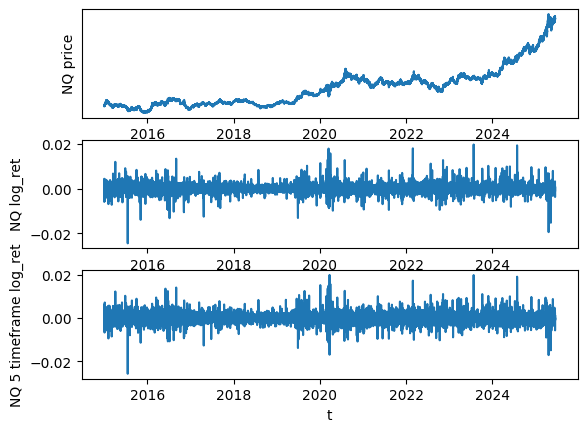

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot((1+data).cumprod())
ax1.set_ylabel('NQ price')
ax1.set_yticks([])
ax2.plot(data)
ax2.set_xlabel('t')
ax2.set_ylabel('NQ log_ret')
ax3.plot(data_five_t)
ax3.set_xlabel('t')
ax3.set_ylabel('NQ 5 timeframe log_ret')

Веделяем выборку для оптимизации и тестовую выборку данных:

In [17]:
days_in_year = 252

def Return(rets):
    """Оценка годовой доходности"""
    return np.mean(rets)*days_in_year


def Volatility(rets):
    """Оценка годовой волатильности"""
    return np.std(rets)*np.sqrt(days_in_year)


def SharpeRatio(rets):
    """Оценка годового коэффициента Шарпа"""
    volatility = Volatility(rets)
    if (volatility>0):
        return Return(rets)/volatility
    else:
        return float('NaN')
        
def statistics_calc(rets, bh, name='_', plot = False):
    """Рисует график эквити портфеля и считает годовые коэф.Шарпа, ретерн и std"""
    sharpe=SharpeRatio(rets)
    ret = Return(rets)
    vol = Volatility(rets)
    if plot:
        plt.plot(rets.cumsum(), label='strategy')
        plt.plot(bh.cumsum(), label='buy & hold')
        plt.xlabel('t')
        plt.legend()
        print('Sharpe ratio = %0.4f'%sharpe)
        print('Annual Return = %0.4f'%ret)
        print('Annual Std = %0.4f'%vol)
        plt.show()
    return  pd.DataFrame([[sharpe,ret,vol]],columns=['Sharpe ratio','Annual return', 'Volatility'], index =[name]) 
 
def weighted_moving_average(series, window_size):

    #вычисление взвешенного скользящего среднего с использованием Hann window
    hann_window = np.hanning(window_size)
    wma = np.convolve(series, hann_window/hann_window.sum(), mode='valid')

    #добавляем NaN в начале массива, чтобы сместить результат
    return np.concatenate([np.full(window_size-1, np.nan), wma])

In [18]:
def lin_reg(data,params):
    alpha = params[0]
    n_han = params[1]
    global win

    periods_for_linear_regression = [int(7*(1.45**x)) for x in range(0, n_han)]


    # log_ret = log_ret_norm.loc[data.index[0]: data.index[-1]]
    log_ret = data['log_ret']/np.std(data['log_ret'])

    df = pd.DataFrame(log_ret.values, index=data.index, columns=['value'])

    period_list = []

    for i in periods_for_linear_regression :
        temp = 's_' + str(i)
        # df[temp] = log_ret.ewm(span=i).mean().shift(1) #использование скользящих средних
        df[temp] =  log_ret.rolling(window=i, win_type=win).mean().shift(1)
        period_list.append(temp)

    df = df.dropna()

    # Создание и обучение модели линейной регрессии
    model = Ridge(alpha=alpha, fit_intercept=True)

    # Разделение данных на тренировочный и тестовый наборы
    X_train = df[period_list]
    y_train = df['value']


    model.fit(X_train, y_train)

    return model, X_train

def lin_reg_test(data_train,data_test,params):
    alpha = params[0]
    n_han = params[1]

    periods_for_linear_regression = [int(7*(1.45**x)) for x in range(0, n_han)]

    data = pd.concat([data_train,data_test])
    time_contact = data_train.index[-1]

    # log_ret = log_ret_norm.loc[data.index[0]: data.index[-1]]
    log_ret = data['log_ret']/np.std(data['log_ret'])

    df = pd.DataFrame(log_ret.values, index=data.index, columns=['value'])

    period_list = []

    for i in periods_for_linear_regression :
        temp = 's_' + str(i)
        # df[temp] = log_ret.ewm(span=i).mean().shift(1) #использование скользящих средних
        df[temp] =  df[temp] =  log_ret.rolling(window=i, win_type=win).mean().shift(1)
        period_list.append(temp)

    df = df.dropna()

    # Создание и обучение модели линейной регрессии
    model = Ridge(alpha=alpha, fit_intercept=True)

    train_df = df[:time_contact]
    test_df = df[time_contact:]

    # Разделение данных на тренировочный и тестовый наборы
    X_train = train_df[period_list]
    y_train = train_df['value']
    X_test = test_df[period_list]
    y_test = test_df['value']

    model.fit(X_train, y_train)

    return model, X_test

In [19]:
def normalization_position_intraday(row, index, vol_daily):
  time = index.time()
  if time in vol_daily.index:
    return (row['position']/(vol_daily.iloc[time,'vol']))*0.0009
  return (row['position']/0.001657)*0.0009

def strategy_lin_reg(data, params, data_train = pd.DataFrame()):
    
    scale = params[0]
    pos_limit = 4
    alpha = params[1]
    n_han = params[2]
    effective_treshold=1.5

    # Предсказание на тестовом наборе
    if (data_train.empty == True):
        model, X = lin_reg(data,[alpha,n_han])
    else:
        model, X = lin_reg_test(data_train,data, [alpha,n_han])

    features=pd.DataFrame(index = X.index) 
        

    features['signal'] = pd.DataFrame(model.predict(X), X.index)
    #Оценка волатильности:
    features['absSignal'] = np.abs(features['signal'])
    features['EmaAbsSignal'] = features['absSignal'].ewm(span=20).mean().shift(1)
    features['signal_vol'] = features['EmaAbsSignal'].ewm(span=400).mean()+0.00001

    #Оценка волатильности актива:
    features['absRet'] = np.abs(data['log_ret'])
    features['EmaAbsRet'] = features['absRet'].ewm(span=20).mean().shift(1)*np.sqrt(20)
    features['vol'] = features['EmaAbsRet'].ewm(span=400).mean()*np.sqrt(400)+0.00001 


    
    features['position'] = ((features['signal']/features['signal_vol']/features['vol']/scale).ewm(10).mean().shift(1)).fillna(0).astype(int)
    
    #Добавляем небольшое сглаживание целевой позиции для уменьшения транзакционных издержек
    features['position'] = features['position'].ewm(alpha=0.1).mean()

    #Убираем заглядывание в будущее (мы не можем испольнить ордер по той же цене, по котрой считали сигнал. Нужно брать цену следующего бара)
    features['position'] = features['position'].shift(1)

    #Торгуем целыми лотами
    features['position'] = features['position'].fillna(0).astype(int)

     #гистерезис
    if effective_treshold > 0:
        prev_pos = 0
        # Доступ к значениям напрямую для ускорения
        positions = features['position'].to_numpy()

        for i in range(len(positions)):
            current_pos = positions[i]
            # Проверка изменения позиции в зависимости от предыдущей
            if abs(current_pos - prev_pos) / (abs(prev_pos) + 0.0001) < effective_treshold:
                positions[i] = prev_pos
            # Обнуление позиции при малом значении
            if abs(positions[i]) < effective_treshold:
                positions[i] = 0
            # Обновление предыдущей позиции
            prev_pos = positions[i]

        # Обновляем 'position' в исходном DataFrame
        features['position'] = positions

    
    #features = features.apply(lambda row: normalization_position_intraday(row, row.name), axis=1)

    # positions = features['position'].to_numpy()
    # index = features.index.to_numpy()
    # for i in range(len(positions)):
    #     current_pos = positions[i]
    #     time = pd.to_datetime(index[i]).time()
    #     if time in vol_daily.index:
    #       positions[i] = (positions[i]/(vol_daily.at[time,'vol']))*0.0009
    #     else:
    #       positions[i] = (positions[i]/(0.001657))*0.0009


    #Лимит на максимальную позицию
    features.loc[features.index[features['position']>pos_limit],'position']=int(pos_limit)
    features.loc[features.index[features['position']<-pos_limit],'position']=-int(pos_limit)      

    #Вычисляем эквити кривую и переводим в дневной таймфрейм для расчета основных статистик
    eq = (data['log_ret']*features['position']-0.00003*features['position'].diff().abs()
         ).fillna(0).resample('1D').agg('sum')
    eq = eq/pos_limit
    bh = data['log_ret'].fillna(0).resample('1D').agg('sum')
    volume = features['position'].diff().abs().sum()
    
    #Считаем статистики и сохраняем результат
    stats=statistics_calc(eq, bh, name="{0}".format(scale)) 
    stats['scale'] = scale

    return stats, eq, bh, volume


Перебор по сетке параметров:

In [20]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def opt_backtest(scale,alpha,n_han,data_train):
    stats_current = strategy_lin_reg(data_train, [scale,alpha,n_han])[0]
    return stats_current['Sharpe ratio'].mean()

def objective(trial,data_train):
    scale = trial.suggest_int("scale", 1, 20, log = True)
    alpha = trial.suggest_float("alpha", 1.0, 5.0, log = True)
    n_han = trial.suggest_int("n_han", 2, 10, log = True)
    

    obj_value = opt_backtest(scale,alpha,n_han,data_train)

    if np.isnan(obj_value):
        obj_value = 0
    
    return obj_value

In [21]:
def optuna_search(data_train):
  study = optuna.create_study(direction = 'maximize')
  study.optimize(lambda trial: objective(trial,data_train), n_trials = 100, show_progress_bar = False, n_jobs = 10)

  best_par = list(study.best_params.values())
  # print(best_par)
  return best_par

In [22]:
def walk_forward_ridge(data, n_splits, x_train):   
  #train выборка в 1.5 раща больше тестовой
  train_size = int((len(data)//(n_splits+1)) * x_train)

  tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=train_size)

  eq_test = pd.DataFrame()
  bh_test = pd.DataFrame()
  volume_test = 0
  for train_index, test_index in tscv.split(data):  
    # Обучающие и тестовые данные  
    data_train, data_test = data.iloc[train_index], data.iloc[test_index]

    data_train.index = pd.to_datetime(data_train.index, format = "%Y-%m-%d %H:%M:%S")
    data_train = data_train[~data_train.index.duplicated(keep = False)]

    data_test.index = pd.to_datetime(data_test.index, format = "%Y-%m-%d %H:%M:%S")
    data_test = data_test[~data_test.index.duplicated(keep = False)]

    best_par = optuna_search(data_train)
    stats, eq,bh, volume = strategy_lin_reg(data_test, best_par, data_train)
    volume_test += volume

    # Сохраняем прогнозы  
    eq_test = pd.concat([eq_test, eq])
    bh_test = pd.concat([bh_test, bh])

  return eq_test, bh_test, volume_test

Считаем эквити на данных, включающих тестовый период:

In [23]:
import logging
optuna.logging.set_verbosity(optuna.logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler("optuna.log", mode="w")
formatter = logging.Formatter("%(asctime)s %(levelname)s %(message)s")
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

optuna.logging.enable_propagation()      
optuna.logging.disable_default_handler()


def opt_backtest_strat(n_splits, x_train, data_t):
    eq, bh, volume = walk_forward_ridge(data_t, n_splits, x_train)
    eq.columns = ["log_ret"]
    eq.index = pd.to_datetime(eq.index)
    print(n_splits, x_train)
    print(volume)
    stats = statistics_calc(eq['log_ret'],bh,plot=True)
    return stats['Sharpe ratio'].mean()

def objective_strat(trial,data_t):
    n_splits = trial.suggest_int("n_splits", 3, 300, log = True)
    x_train = trial.suggest_float("x_train", 1.5, 15.0, log = True)
    
    obj_value = opt_backtest_strat(n_splits,x_train,data_t)

    if np.isnan(obj_value):
        obj_value = 0
    
    return obj_value
def optuna_search_strat(data_t):
  study = optuna.create_study(direction = 'maximize')
  study.optimize(lambda trial: objective_strat(trial,data_t), n_trials = 20, show_progress_bar = False, n_jobs = 4)
  best_par = list(study.best_params.values())
  return best_par

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To reta

240.0
Sharpe ratio = 0.6935
Annual Return = 0.0887
Annual Std = 0.1279


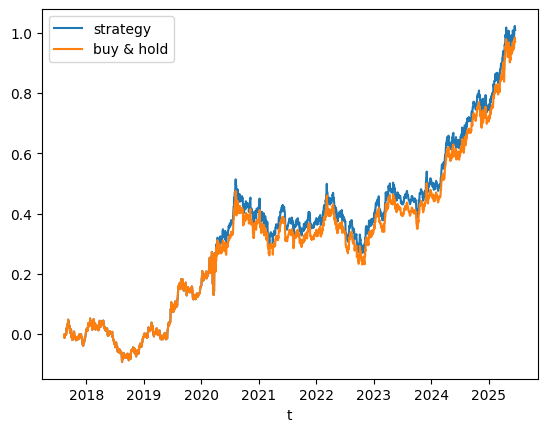

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


214.0
Sharpe ratio = 0.6582
Annual Return = 0.0832
Annual Std = 0.1264


c:\Users\etsvetkov\algotrading\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


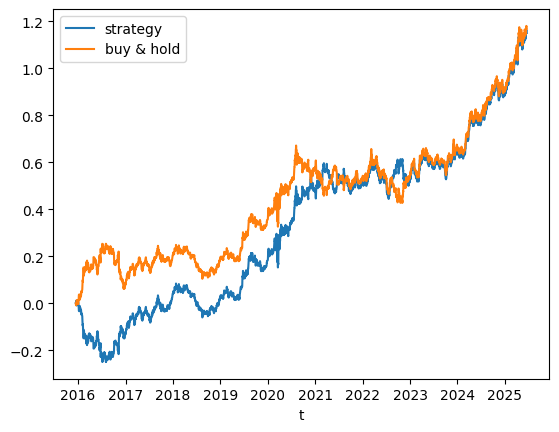

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


1122.0
Sharpe ratio = 0.3051
Annual Return = 0.0383
Annual Std = 0.1257


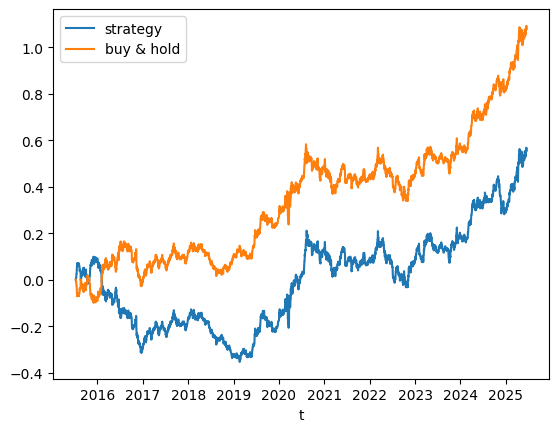

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


900.0
Sharpe ratio = 0.1458
Annual Return = 0.0183
Annual Std = 0.1254


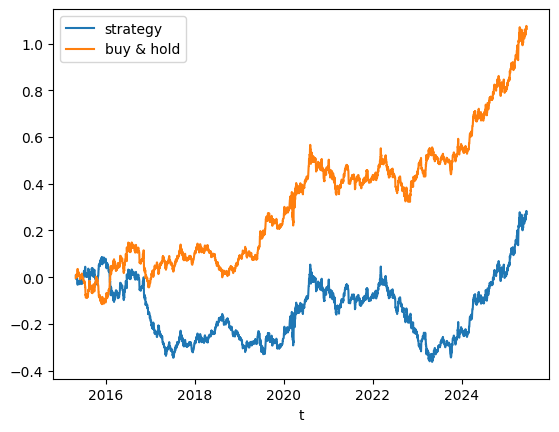

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


1938.0
Sharpe ratio = 0.1704
Annual Return = 0.0212
Annual Std = 0.1241


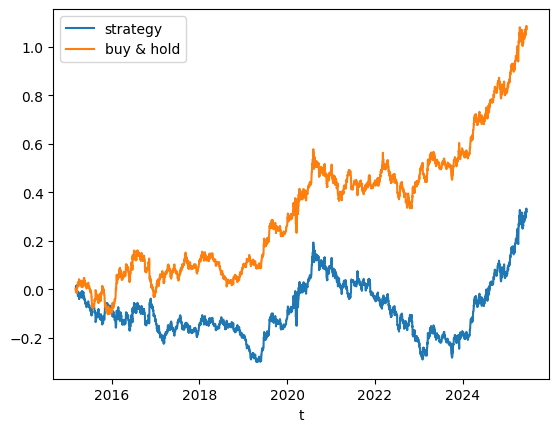

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


778.0
Sharpe ratio = 0.2557
Annual Return = 0.0320
Annual Std = 0.1251


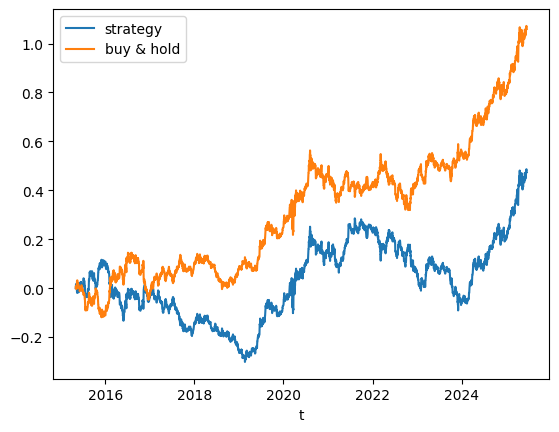

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


4107.0
Sharpe ratio = 0.2592
Annual Return = 0.0312
Annual Std = 0.1203


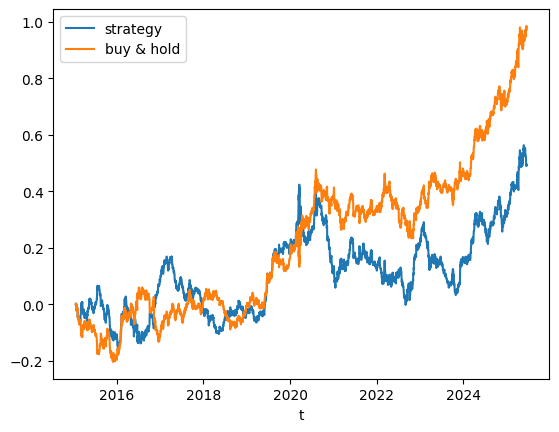

1034.0
Sharpe ratio = 0.5398
Annual Return = 0.0681
Annual Std = 0.1261


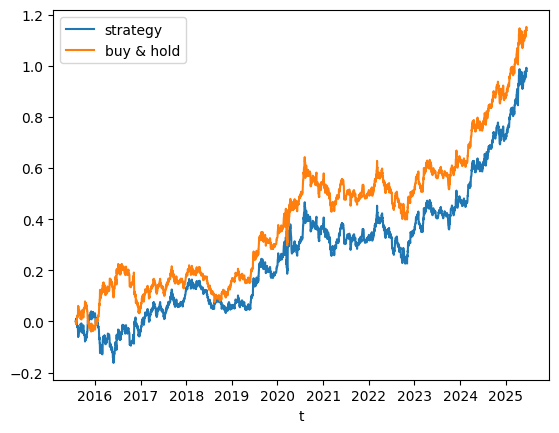

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To reta

68.0
Sharpe ratio = 0.6673
Annual Return = 0.0851
Annual Std = 0.1276


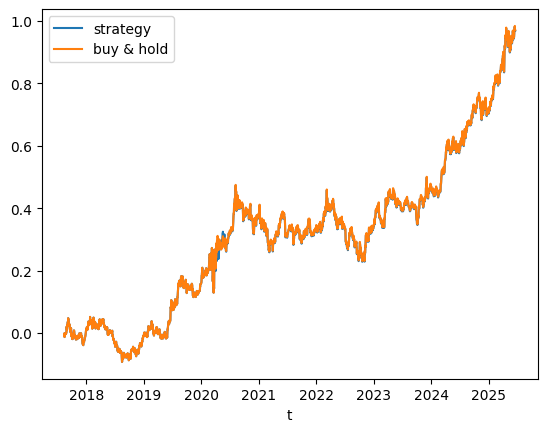

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


284.0
Sharpe ratio = 0.4530
Annual Return = 0.0568
Annual Std = 0.1255


c:\Users\etsvetkov\algotrading\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


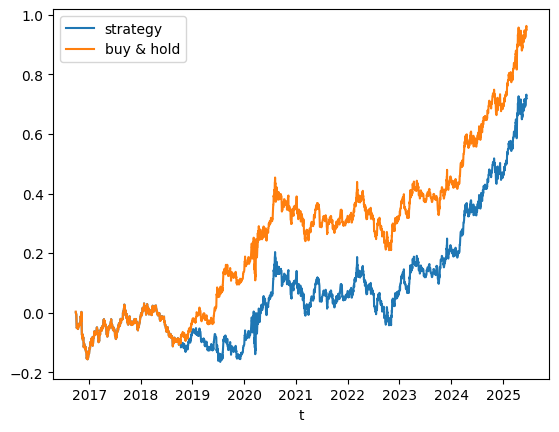

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


2778.0
Sharpe ratio = 0.0169
Annual Return = 0.0021
Annual Std = 0.1230


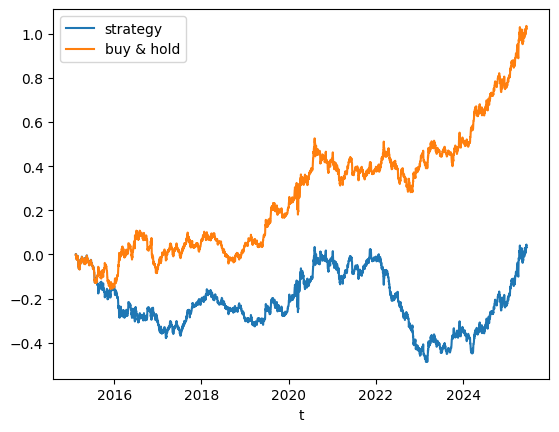

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


1354.0
Sharpe ratio = 0.4606
Annual Return = 0.0575
Annual Std = 0.1250


c:\Users\etsvetkov\algotrading\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


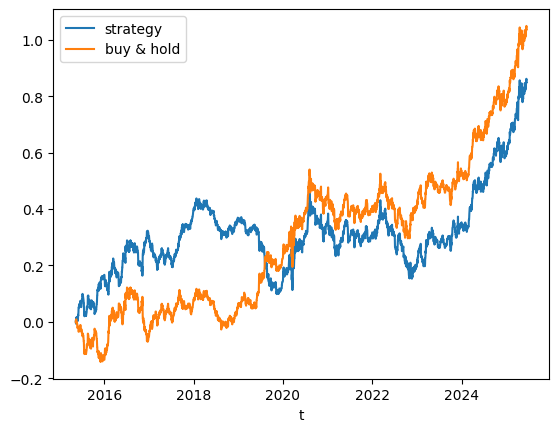

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


68.0
Sharpe ratio = 0.6673
Annual Return = 0.0851
Annual Std = 0.1276


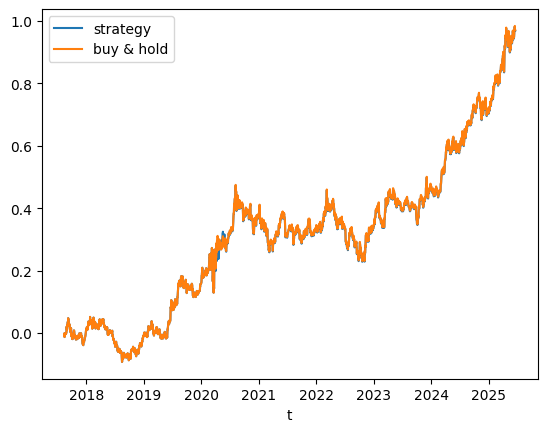

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


68.0
Sharpe ratio = 0.6673
Annual Return = 0.0851
Annual Std = 0.1276


c:\Users\etsvetkov\algotrading\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


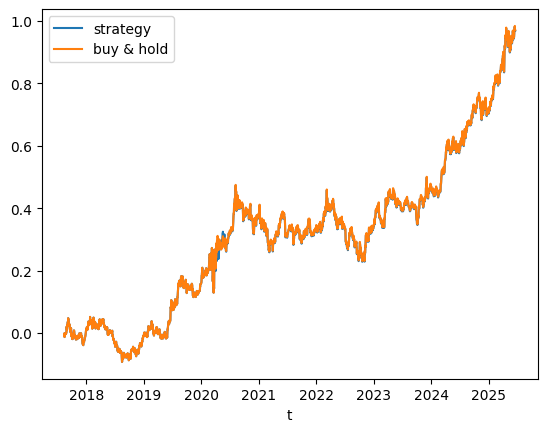

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


68.0
Sharpe ratio = 0.6673
Annual Return = 0.0851
Annual Std = 0.1276


c:\Users\etsvetkov\algotrading\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\etsvetkov\algotrading\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


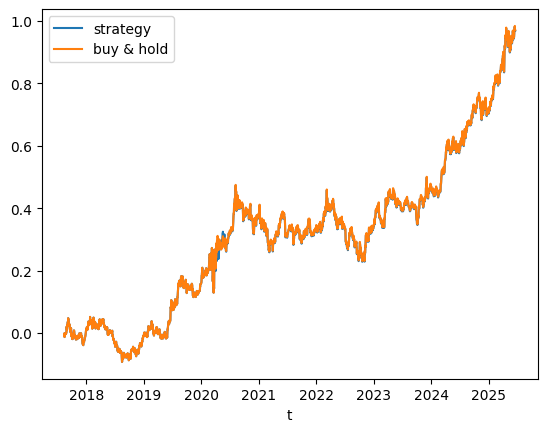

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


308.0
Sharpe ratio = 0.6152
Annual Return = 0.0778
Annual Std = 0.1264


c:\Users\etsvetkov\algotrading\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\etsvetkov\algotrading\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


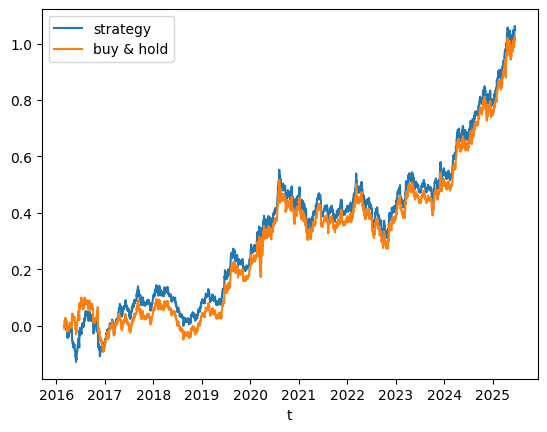

C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eq_test = pd.concat([eq_test, eq])
C:\Users\etsvetkov\AppData\Local\Temp\ipykernel_2952\578123014.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bh_test = pd.concat([bh_test, bh])


758.0
Sharpe ratio = 0.3032
Annual Return = 0.0380
Annual Std = 0.1255


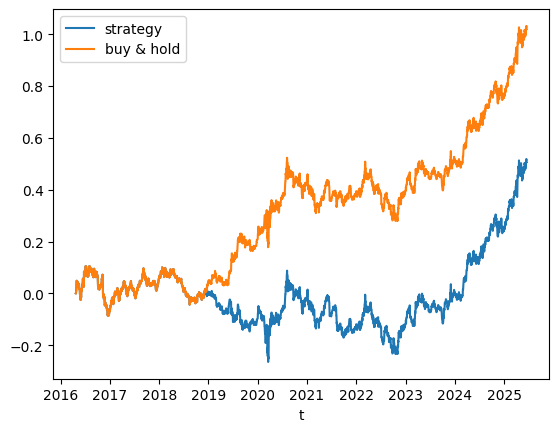

178.0
Sharpe ratio = 0.5784
Annual Return = 0.0723
Annual Std = 0.1250


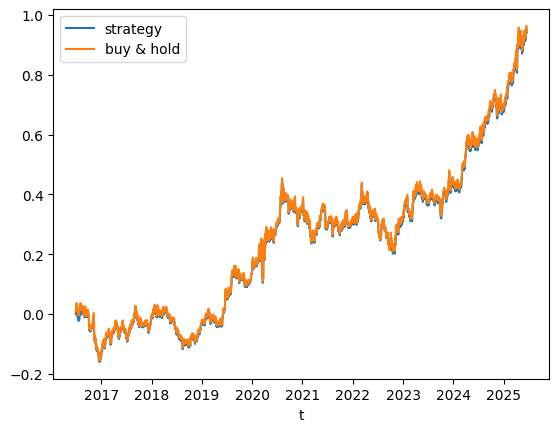

4690.0
Sharpe ratio = 0.2394
Annual Return = 0.0283
Annual Std = 0.1182


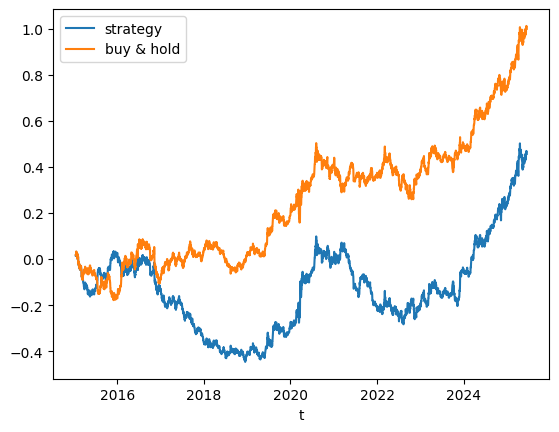

4784.0
Sharpe ratio = 0.2807
Annual Return = 0.0331
Annual Std = 0.1178


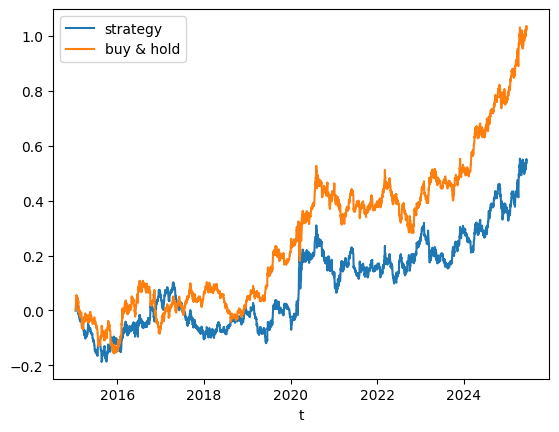

[3, 10.235582036387298]

In [24]:
optuna_search_strat(data_five_t)